In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import nltk

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dataset = pd.read_csv('/work/fifa_world_cup_2022_tweets.csv')

In [3]:
dataset.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [4]:
dataset['Date Created'] =  pd.to_datetime(dataset['Date Created'], format='%Y-%m-%d %H:%M:%S')

dataset.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Unnamed: 0       22524 non-null  int64              
 1   Date Created     22524 non-null  datetime64[ns, UTC]
 2   Number of Likes  22524 non-null  int64              
 3   Source of Tweet  22524 non-null  object             
 4   Tweet            22524 non-null  object             
 5   Sentiment        22524 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 1.0+ MB


## Visualisasi Data

In [5]:
dataset.isnull( ).sum( )

Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

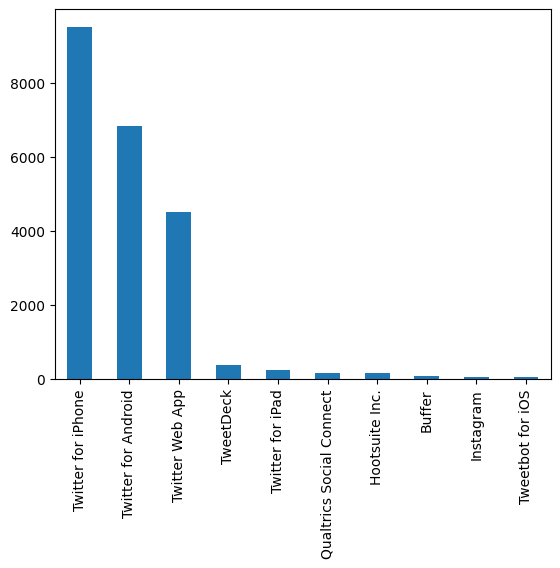

In [6]:
source_t =  dataset['Source of Tweet'].value_counts()
source_t.head(10).plot.bar()
plt.show()

Pengguna iphone paling banyak tweet di world cup

In [7]:
most_liked = dataset.sort_values(by=['Number of Likes'], ascending=False)
most_liked.head(10)

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
1287,1287,2022-11-20 19:39:11+00:00,316867,Twitter for iPhone,I can’t express my gratitude and happiness for...,positive
17359,17359,2022-11-20 12:41:31+00:00,31517,Twitter Media Studio,Football Legend Eric Cantona reminds football ...,neutral
21267,21267,2022-11-20 06:17:00+00:00,20016,Twitter Web App,⚽️ #BitKeep FootBall Carnival Main Event is co...,positive
528,528,2022-11-20 22:20:55+00:00,5847,TweetDeck,WATCH: BTS's #Jungkook Performs At #WorldCup20...,neutral
20073,20073,2022-11-20 09:05:12+00:00,5555,Twitter for iPhone,The 👑 Leo with Louis Vuitton 💧 #WorldCup2022 h...,positive
15332,15332,2022-11-20 14:57:02+00:00,5484,Twitter Web App,Need them at the World Cup opening ceremony 😮\...,neutral
20101,20101,2022-11-20 09:02:09+00:00,5430,TweetDeck,WATCH: #BTS's #Jungkook Shares His Support For...,neutral
212,212,2022-11-20 23:06:08+00:00,3172,Twitter Media Studio,"""It's Palestine...""\n\nLebanese fans refuse to...",negative
1635,1635,2022-11-20 19:00:00+00:00,2428,Sprinklr Publishing,".@reymysterio, @fightbobby, @BiancaBelairWWE a...",neutral
5761,5761,2022-11-20 16:23:30+00:00,2370,Twitter for Android,Qatar's Goalkeeper 😂\n\n#WorldCup2022 https://...,neutral


most liked tweet adalah tentang jungkook

## Data cleaning and prep

Hapus tweet dengan sentiment neutral

In [8]:
dataset = dataset[dataset.Sentiment != 'neutral']

In [9]:
# Removing the unnecessary columns.
dataset = dataset[['Sentiment','Tweet']]
# Replacing the values to ease understanding.
dataset['Sentiment'] = dataset['Sentiment'].replace(4,1)


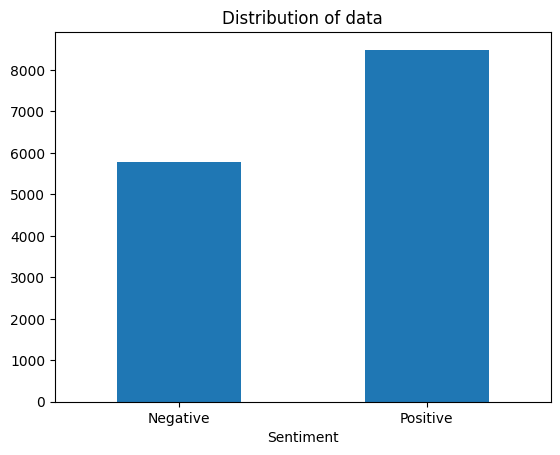

In [10]:
# Plotting the distribution for dataset.
ax = dataset.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['Tweet']), list(dataset['Sentiment'])

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [13]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 3 seconds


### Analysis Word Cloud

Negative word

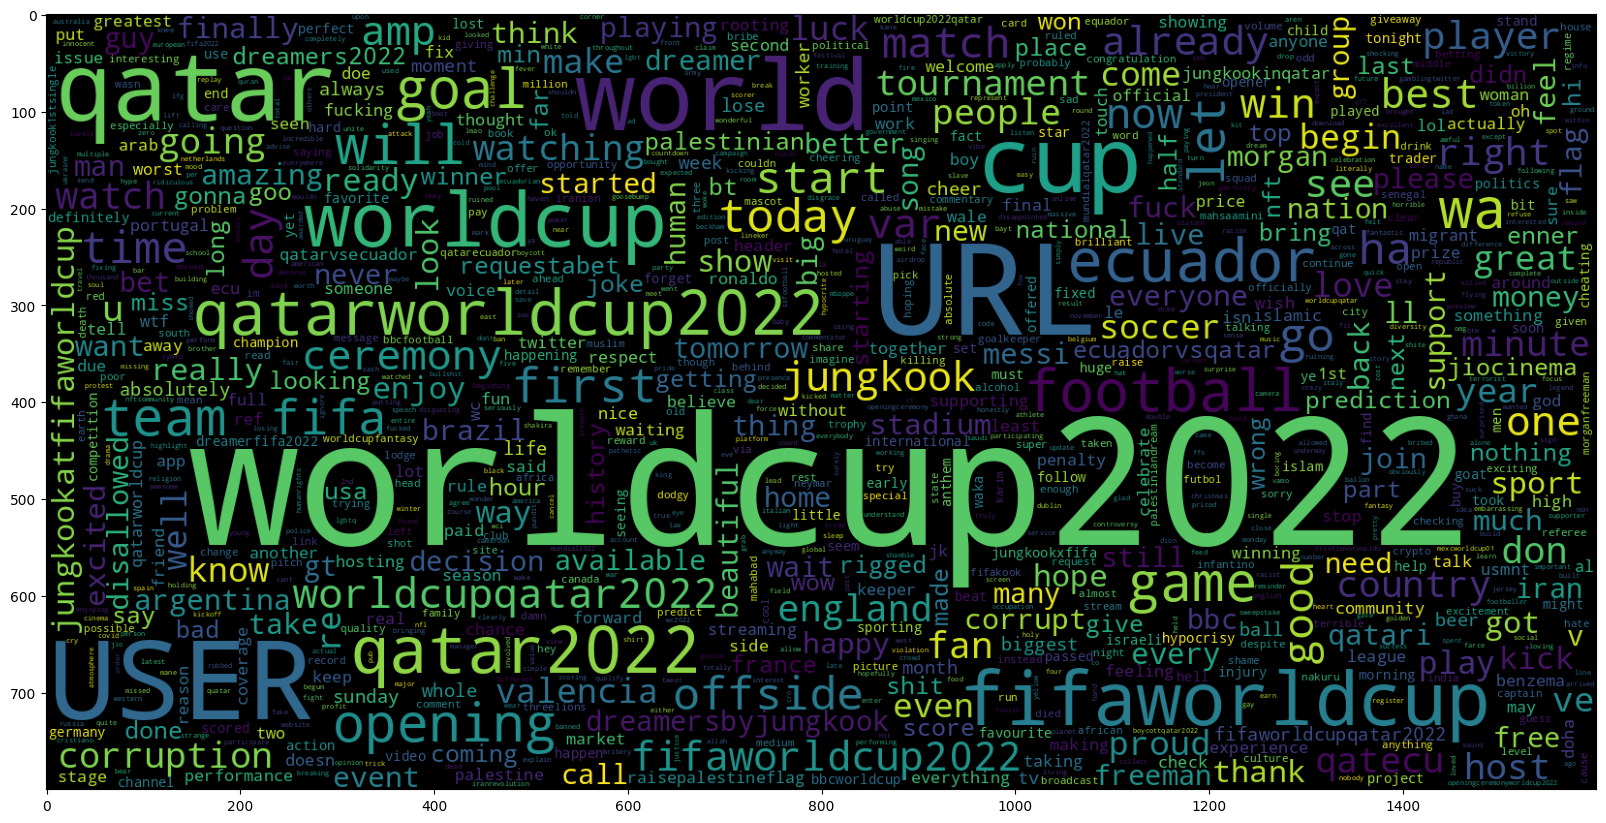

In [14]:
# Filter the DataFrame to include only rows with 'sentiment' column as 'negative'
negative_data = dataset[dataset['Sentiment'] == 'negative']

negative_data = processedtext
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative_data))
plt.imshow(wc)

positive word

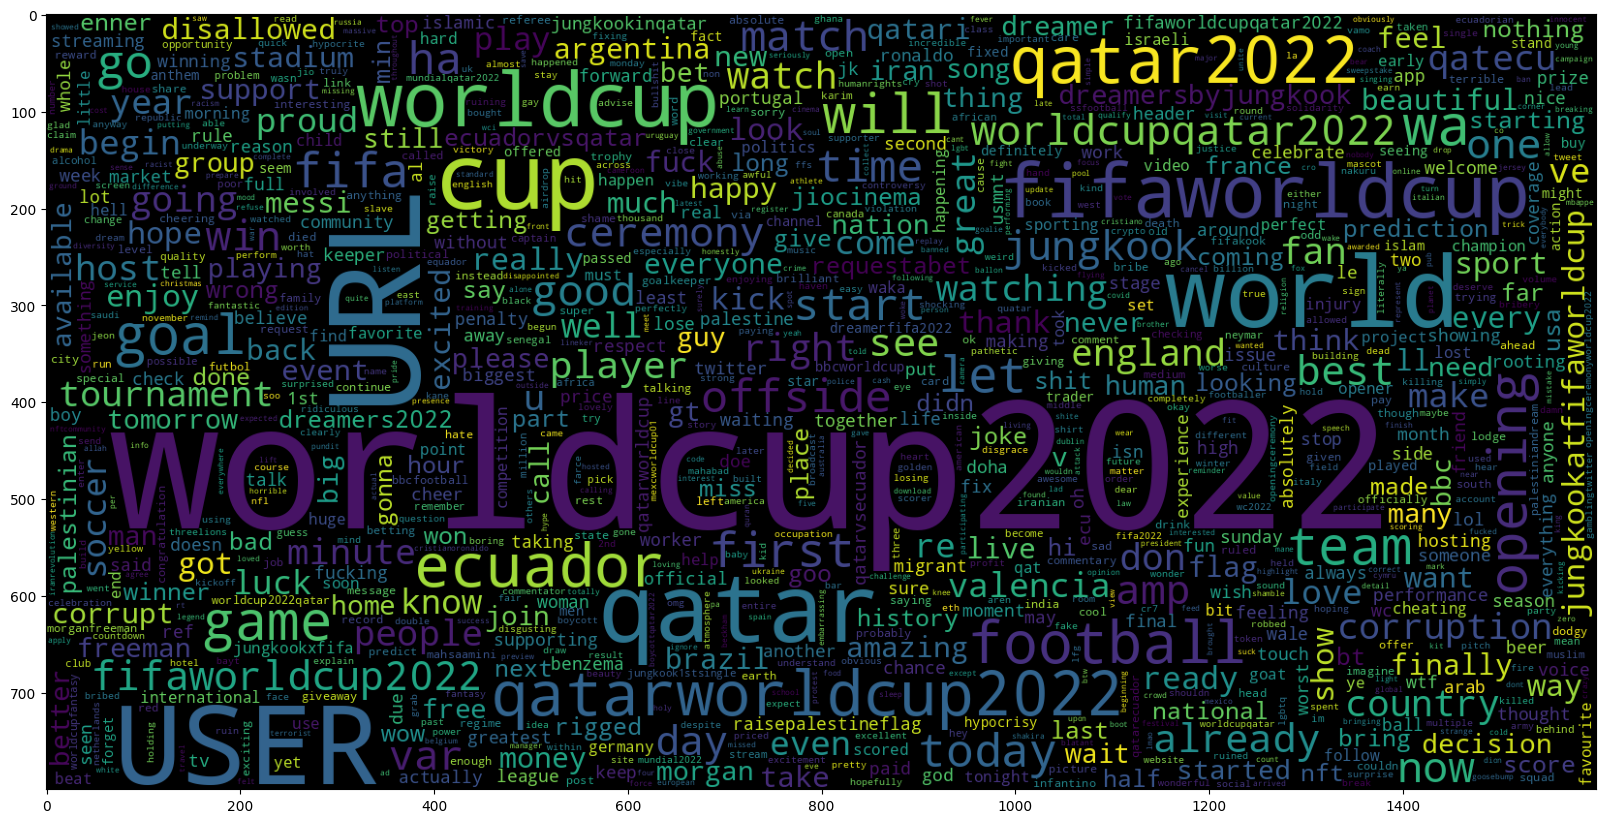

In [15]:
# Filter the DataFrame to include only rows with 'sentiment' column as 'negative'
positive_data = dataset[dataset['Sentiment'] == 'positive']

positive_data = processedtext
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(positive_data))
plt.imshow(wc)

## Train test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


mengubah string menjadi uniqu symbol dengan vectorizer

In [17]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  110112
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [19]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    negative       0.94      0.68      0.79       279
    positive       0.83      0.97      0.89       435

    accuracy                           0.86       714
   macro avg       0.88      0.83      0.84       714
weighted avg       0.87      0.86      0.85       714



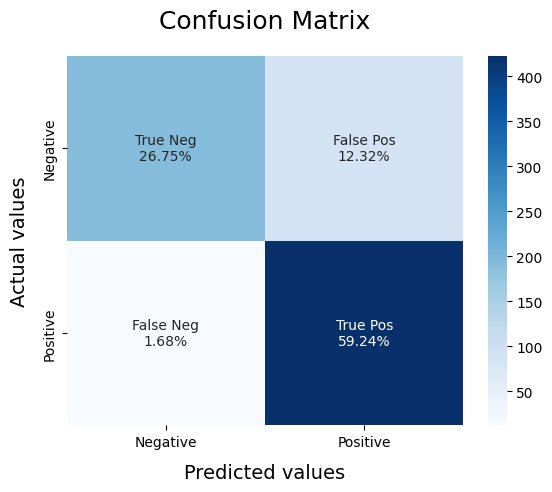

In [20]:
from sklearn.naive_bayes import MultinomialNB

# Create and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Evaluate the Naive Bayes classifier using the model_Evaluate function
model_Evaluate(nb_classifier)

              precision    recall  f1-score   support

    negative       0.90      0.84      0.87       279
    positive       0.90      0.94      0.92       435

    accuracy                           0.90       714
   macro avg       0.90      0.89      0.89       714
weighted avg       0.90      0.90      0.90       714



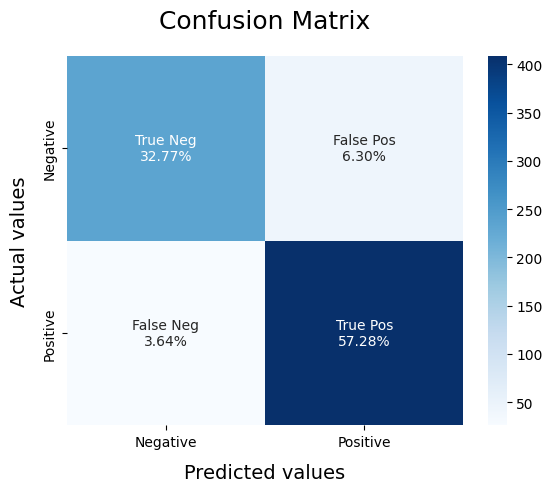

In [21]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

## Saving the Models

In [22]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-naiveby.pickle','wb')
pickle.dump(nb_classifier, file)
file.close()

Aplikasi Logistic Regression

In [23]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('/work/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/work/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

     # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  negative
1       May the Force be with you.  positive
2  Mr. Stark, I don't feel so good  negative


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6ab7c2c0-ab4e-4a88-92ea-c172b9750384' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>